(automate-project-git-source)=
# Create a project using a Git source


This example shows how to create a project in MLRun for CI/CD automation based on a remote source, in this case Git.
The process is equivalent to using tar.gz, zip archive files. This example assumes you have functions that are ready 
to run, and that you already cloned the files to your local file system.<br>

The flow covers these steps to create a CI/CD project in MLRun:
1. [Before you start](#before-you-start)
2. [Creating a project](#creating-a-project)
2. [Setting a project source: remote or archive](#setting-a-project-source-either-remote-or-archive)
3. [Setting and running functions using Git source code](#setting-and-running-functions-using-git-source-code)
4. [Setting a workflow](#setting-a-workflow)
4. [Running a workflow using a Git source](#running-a-workflow-using-a-git-source)
5. [Setting and registering the project artifacts](#setting-and-registering-the-project-artifacts)
6. [Creating and saving the project YAML](#creating-and-saving-the-project-yaml)
7. [Creating and pushing changes to your Git repo or archive file](#creating-and-pushing-changes-to-your-git-repo-or-archive-file)

## Before you start

Install MLRun. If MLRun is not installed use ``pip install mlrun==<mlrun server version>`` or <br>``sh align_mlrun.sh`` 
(the default MLRun installer that automatically installs the server version).


In [1]:
import mlrun

Before running this notebook, clone the Git repo to your local machine.

In [2]:
# delete the clone folder if exists
!rm -rf ./clone

In [3]:
# clone the repo to your local machine
!git clone https://github.com/mlrun/ci-cd-tutorial.git ./clone

Cloning into './clone'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 209 (delta 118), reused 129 (delta 53), pack-reused 0
Receiving objects: 100% (209/209), 162.20 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Creating a project

In [4]:
# Create a new project or load it from DB
project = mlrun.get_or_create_project(name="new-ci-cd-proj", context="./clone")

> 2023-05-17 09:04:46,772 [info] loaded project new-ci-cd-proj from MLRun DB


or for loading from a private repo:

```
# project = mlrun.get_or_create_project(name='new-ci-cd-proj',context='./',init_git=True,secrets={"GIT_TOKEN":<github-token>})
```

See more details in {py:class}`~mlrun.projects.get_or_create_project` and {ref}`secrets`.


When you create a new project, MLRun creates a light project YAML, for example: 
````
kind: project
metadata:
  name: new-ci-cd-proj
  created: '2022-06-30T09:41:05.612000'
spec:
  functions: []
  workflows: []
  artifacts: []
  desired_state: online
status:
  state: online
````

As you proceed, more information (project metadata) is added to the project YAML.

## Setting a project source, either remote or archive 

Define the project source, and optionally `pull_at_runtime` flag value, and the project working dir, and add them to 
the `project.yaml` by using the {py:class}`~mlrun.projects.MlrunProject.set_source` method.   
To copy these values also to the functions spec, set `with_repo=True` in the `project.set_function` method. 

- If `pull_at_runtime=True` MLRun loads the git/archive repo into the function container at run time and does not require a build. (This is simpler when developing, for production it’s preferable to build the image with the code.)
- If `pull_at_runtime` is **not set to `True`**, you need to deploy the functions (with `function.deploy()`) to build a container.

See more about `pull_at_runtime` in [Loading the code from container vs. loading the code at runtime](./git-best-practices.html#loading-the-code-from-container-vs-loading-the-code-at-runtime).<br>
See also {py:class}`KubejobRuntime.with_source_archive <mlrun.runtimes.KubejobRuntime.with_source_archive>` and {py:class}`RemoteRuntime.with_source_archive <mlrun.runtimes.RemoteRuntime.with_source_archive>`.

In [5]:
# Add the git branch or references to the source e.g.: 'git://url/org/repo.git#<branch-name or refs/heads/.. or refs/tags/..>`.
source = "git://github.com/mlrun/ci-cd-tutorial.git"

In [6]:
# Set the project source
project.set_source(source=source, pull_at_runtime=True)

## Setting and running functions using Git source code

This section describes: [fetching the data](#fetching-the-functions-data); [running the function](#running-the-function); [training the model using the fetched data](#training-the-model); and [serving the function](#serving-the-function).

The code source files are usually stored under a folder named `./src` in the project context, <br>
for example: `./project-context/src/data_fetch.py`

### Setting the project's functions

To set the function's definitions, use the {py:class}`~mlrun.projects.MlrunProject.set_function` method. 
This sets the function's metadata in the project YAML, for example: 
function source (YAML, py, ipynb, function object), name of the function, function handler, function image, 
function kind, and function requirements.

See more details in {py:class}`~mlrun.projects.MlrunProject.set_function`.

### Fetching the function's data

```{admonition} Tip: Using tags 
This example includes a `tag` value that is used as the Git tag for the release after completing the development. The tag 
must be added manually to the function. (This tag is internal to MLRun and is not taken from Git.)
```

In [7]:
# Set data_fetch function to the project.yaml file
project.set_function(
    func="./src/data_fetch.py",
    name="data-fetch",
    handler="data_fetch",
    kind="job",
    image="mlrun/mlrun",
    with_repo=True,
    tag="v4",
)

### Running the function

After you set the function in the project, get the function object with the 
{py:class}`~mlrun.projects.MlrunProject.get_function` method.


```{admonition} Tip: Change the function spec with get_function
You can use the `get_function` method to change the function spec. For example, if you  
change the function resources and then run the function, it runs with those changes and the changes are stored in 
the project object cache:

      
      data_fetch_func = mlrun.get_function('data-fetch')
      data_fetch_func.with_requests(mem='1G',cpu=3)
      data_fetch_run = project.run_function('data-fetch')
      
```

Run the function using the {py:class}`~mlrun.projects.MlrunProject.run_function` method both to 
[run jobs locally](#running-the-function-locally) 
and [remotely on the runtime/cluster](#running-the-function-remotely-on-your-cluster). If 
there are any requirements, you need to build a new 
image before you run a function. See more details in {ref}`build-function-image`.

#### Running the function locally

First, run the function using the code files from your project context folder on your local file system, for debugging the function. Once you are satisfied, continue with [Running the function remotely on your cluster](#running-the-function-remotely-on-your-cluster). 

To run the code locally, use `local=True`.

In [8]:
data_fetch_run = project.run_function(
    function="data-fetch", returns=["train-dataset", "test-dataset"], local=True
)

> 2023-05-17 09:04:46,993 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': 'a6e5cc8f573e41f6ae6ef1c049b6e50a', 'db': 'http://mlrun-api:8080'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-ci-cd-proj-shapira,...49b6e50a,0,May 17 09:04:47,completed,data-fetch-data-fetch,v3io_user=shapirakind=owner=shapirahost=jupyter-shapira-7fc985f9db-cp8x9release=v3,,,,train-datasettest-dataset


> 2023-05-17 09:04:50,355 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


#### Running the function remotely on your cluster

```{admonition} Tip: Using a relative handler
If your code is saved to your remote source, you can run the function from a remote source by adding 
`with_repo=True`. You can also specify a relative handler (folder_name.file_name.function_handler) to point to the python 
code file. (This paradigm does not support running functions in local.)

    
      project.set_function(name=\"training\",
          handler=\"function.model_training\",
          image=\"mlrun/mlrun\", kind=\"job\",with_repo=True
          )
      
```
Use the code files from the remote project source (`local=False`).

In [9]:
data_fetch_run = project.run_function(
    function="data-fetch", returns=["train-dataset", "test-dataset"], local=False
)

> 2023-05-17 09:04:50,395 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '860b9700cd3f4724a0669cb7c9732beb', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:04:50,649 [info] Job is running in the background, pod: data-fetch-data-fetch-qd874
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-ci-cd-proj-shapira,...c9732beb,0,May 17 09:04:54,completed,data-fetch-data-fetch,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.1-rc5mlrun/client_python_version=3.7.6host=data-fetch-data-fetch-qd874release=v3,,,,train-datasettest-dataset


> 2023-05-17 09:05:03,834 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [10]:
data_fetch_run.outputs

{'train-dataset': 'store://artifacts/new-ci-cd-proj-shapira/data-fetch-data-fetch_train-dataset:860b9700cd3f4724a0669cb7c9732beb',
 'test-dataset': 'store://artifacts/new-ci-cd-proj-shapira/data-fetch-data-fetch_test-dataset:860b9700cd3f4724a0669cb7c9732beb'}

In [11]:
data_fetch_run.artifact("train-dataset").as_df().sample(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
14,0.655400,1.357176,-0.380252,2.236612,0.102893,-0.038678,0.101061,1.555770,1.116734,0.146883,...,-2.132336,0.739735,0.452615,0.299427,0.683967,-0.089078,0.609046,-0.895865,-0.578405,1
27,0.834107,0.572216,-0.872751,0.519342,-1.101798,0.259935,0.398852,-0.299485,0.821154,0.018271,...,-1.634293,-0.618584,1.354337,-1.136238,1.248243,-0.593805,0.266741,1.180665,1.212383,1
79,-2.040370,3.446461,-0.269668,-0.875862,1.347329,1.412033,0.764714,2.161531,0.390874,-0.900138,...,-0.904111,2.640541,-2.483898,-1.619484,-3.676358,0.704040,-3.192003,1.669527,0.782062,1


### Training the model

In [12]:
project.set_function(
    func="./src/train.py",
    name="train",
    handler="train",
    kind="job",
    image="mlrun/mlrun",
    with_repo=True,
    tag="v4",
)

In [13]:
train_run = project.run_function(
    function="train",
    inputs={
        "train_data": data_fetch_run.outputs["train-dataset"],
        "test_data": data_fetch_run.outputs["test-dataset"],
    },
)

> 2023-05-17 09:05:04,113 [info] Storing function: {'name': 'train-train', 'uid': '423d664e6e684b1fb9acc9e62189d5b4', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:05:04,362 [info] Job is running in the background, pod: train-train-7z8z8
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-ci-cd-proj-shapira,...2189d5b4,0,May 17 09:05:08,completed,train-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.1-rc5mlrun/client_python_version=3.7.6host=train-train-7z8z8release=v3,train_datatest_data,,accuracy=0.85f1_score=0.8421052631578948precision_score=1.0recall_score=0.7272727272727273,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2023-05-17 09:05:25,610 [info] run executed, status=completed: {'name': 'train-train'}


### Serving the function

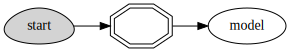

In [14]:
# Create a serving function object
serving = mlrun.new_function(
    name="serving", kind="serving", image="mlrun/mlrun", tag="v4"
)

# Add a model to the model serving function object
serving.add_model(
    key="model",
    model_path=train_run.outputs["model"],
    class_name="mlrun.frameworks.sklearn.SklearnModelServer",
    requirements=["scikit-learn"],
)

# Plot the serving graph
serving.spec.graph.plot(rankdir="LR")

In [15]:
# Save the function spec into a .yaml file and register it in the project
serving.export(target=f"./{project.context}/function_spec/serving.yaml")
project.set_function(func="./function_spec/serving.yaml", name="serving")

> 2023-05-17 09:05:25,815 [info] function spec saved to path: ././clone/function_spec/serving.yaml


```{admonition} CI/CD configuration considerations
- When creating a serving function, the function spec contains metadata of the function steps or the serving function 
models. Therefore, you need to create a function.yaml file by using the {py:class}`~mlrun.runtimes.BaseRuntime.export` 
method that exports the function object to a yaml file (that is saved in the function_spec folder). Then set the function 
with this yaml file. This approach saves all of the function spec for future deployments. (If you don't set the function yaml, you'll need to set the function steps or models to the function when loading the project.)
For example:<br>
       
       <function object>.export('./function_spec/model_training.yaml')
       project.set_function(
             func="training.yaml",name='training',with_repo=True,kind='serving')
       
- Additionally, if you want to change the default function spec values, e.g. resources, node-selector and more, and want to 
make this change constant, you need to create a yaml function file and use the yaml function in the `set_function` method.
- When setting a nuclio function, the function handler is a combination of the `file_name::function_handler`, for example:
`project.set_function(name='nuclio',handler='multi:multi_3',kind='nuclio',image='mlrun/mlrun',with_repo=True)`

- If your `nuclio_func` is inside a folder, the path is:</br>
`handler="folder1.folder2.folder3.nuclio_func:nuclio_handler"`
```

To deploy a remote function, e.g. serving and nuclio kinds, use the {py:class}`~api/mlrun.projects.deploy_function` method.

In [16]:
# Serve the function
serving_func = project.deploy_function(
    function="serving",
    models=[
        {
            "key": "model",
            "model_path": train_run.outputs["model"],
            "class_name": "mlrun.frameworks.sklearn.SklearnModelServer",
        }
    ],
)

> 2023-05-17 09:05:25,839 [info] Starting remote function deploy
2023-05-17 09:05:26  (info) Deploying function
2023-05-17 09:05:26  (info) Building
2023-05-17 09:05:26  (info) Staging files and preparing base images
2023-05-17 09:05:26  (info) Building processor image
2023-05-17 09:06:26  (info) Build complete
2023-05-17 09:06:34  (info) Function deploy complete
> 2023-05-17 09:06:37,264 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-new-ci-cd-proj-shapira-serving-v3.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['new-ci-cd-proj-shapira-serving-v3-new-ci-cd-proj-shapira.default-tenant.app.cust-cs-il-3-5-2.iguazio-cd2.com/']}


In [17]:
my_data = """{"inputs":[[-0.60150011,  0.51150308,  0.25701239, -1.51777297, -1.82961288,
         0.22983693, -0.40761625,  0.82325082,  1.1779216 ,  1.08424275,
        -0.7031145 , -0.40608979, -0.36305977,  1.28075006,  0.94445967,
         1.19105828,  1.93498414,  0.69911167,  0.50759757,  0.91565635]]}"""

In [18]:
serving_func.function.invoke("/", my_data)

> 2023-05-17 09:06:37,342 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-new-ci-cd-proj-shapira-serving-v3.default-tenant.svc.cluster.local:8080/'}


{'id': '8ca4f4ef-7765-4d50-8a43-1e77a15e433f',
 'model_name': 'model',
 'outputs': [1]}

## Setting a workflow

After you completed developing your functions (in this example: `data_fetch`, `training`, and `serving`), 
continue with creating a workflow that runs those functions serially. For more information about workflows and an 
example of a `workflow.py` file, see {ref}`build-run-workflows-pipelines`.

To set a workflow to a project, use the {py:class}`~mlrun.projects.MlrunProject.set_workflow` method. This method adds or 
updates a workflow, and specifies a name and the code path in the project.yaml file

This example adds a workflow named main that points to a file located in <br>`./< project-context >/src/workflow.py`

In [19]:
project.set_workflow("main", "./src/workflow.py")

## Running a workflow using a Git source
To run the workflow, use the {py:class}`~mlrun.projects.MlrunProject.run` method. With {py:class}`~mlrun.projects.MlrunProject.run` you can run a workflow 
or schedule a workflow using kubeflow pipelines by specifying the workflow name or the workflow file path.

To specify running remote, use `remote`.

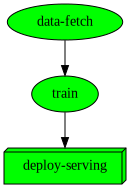

uid,start,state,name,parameters,results
...d1cc13bd,May 17 09:07:23,completed,train,,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0
...2476131c,May 17 09:06:53,completed,data-fetch,,


626a345a-b67f-4eb0-9a3b-4850185ada10

In [20]:
# Run the workflow named main and wait for pipeline completion (watch=True)
project.run("main", watch=True, engine="remote:kfp")

### Running a scheduled workflow

For more information about scheduling workflows, see {ref}`scheduled-jobs`.

In [21]:
project.run("main", schedule="0 * * * *")

> 2023-05-17 09:09:34,482 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-05-17 09:09:34,485 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-05-17 09:09:34,489 [info] Storing function: {'name': 'main', 'uid': '88a2eecd5cd14c339529f2c7ced3a011', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:09:34,854 [info] task schedule modified: {'schedule': '0 * * * *', 'project': 'new-ci-cd-proj-shapira', 'name': 'main'}


## Setting and registering the project artifacts

To register artifacts to a project, use the {py:class}`~mlrun.projects.MlrunProject.set_artifact` method. By adding/setting an artifact in the project spec, they are registered upon loading the project. 
In general, use this method when you want to register an artifact when loading a project, for example:
* You developed a model artifact in the development system and you want to use this model file in production.
* There are artifacts you want to register by default when you load or create a project.

```{admonition} Tip
Do not embed the artifact object in the project yaml. This increases the size of the project yaml file and could affect the project during loading and saving.
```
```{admonition} Registering artifacts in multiple environments
To register artifacts in multiple environments, for example dev and production, you must upload your artifacts to a remote storage e.g. S3. You can change your project artifact path using the MLRun UI or MLRun, for example:
```
```
project.artifact_path='s3:<bucket-name/..'
```

In [22]:
# get the model object to register
model_obj = project.get_artifact("model")

In [23]:
# print a target path
print(model_obj.target_path)

v3io:///projects/new-ci-cd-proj-shapira/artifacts/626a345a-b67f-4eb0-9a3b-4850185ada10/train/0/model/


In [24]:
# print model file
model_obj.model_file

'model.pkl'

In [25]:
# register the model artifact to the project
project.set_artifact(
    key="model-test",
    artifact=mlrun.artifacts.ModelArtifact(model_file=model_obj.model_file),
    target_path=model_obj.target_path,
)

```{admonition} Artifact types
By default, the artifact type is equal to `mlrun.artifacts.Artifact()`. To specify different types, use the relevant 
artifact object. Then you can specify specific parameters to the artifact object type. See more details in {ref}`artifacts`.

### Registering the runtime values together with their artifacts
When MLRun creates an artifact there are values that are processed in runtime e.g. dataset preview or model metrics. These 
values are stored in the artifact spec. If you want to store the artifact spec for registering the artifact with those 
values, export the artifact object to a folder named `./artifacts` and set the artifact using the artifact.yaml file. For example:

```
model_obj = project.get_artifact('model')
model_obj.export(./artifact/model_artifact.yaml)
project.set_artifact(key='model',artifact='./model_artifact.yaml')
```

## Creating and saving the project YAML

The project YAML contains metadata about the project, for example, all the functions set to the project, the artifacts, and the workflow. When you load the project, it loads with all of these functions, artifacts, and workflow.

In general, MLRun uses this metadata to create objects, for example, function objects, and then uses those objects to 
run the functions.

In [26]:
print(project.to_yaml())

kind: project
metadata:
  name: new-ci-cd-proj-shapira
  created: '2023-05-17T08:51:02.127000'
spec:
  functions:
  - url: ./src/data_fetch.py
    name: data-fetch
    kind: job
    image: mlrun/mlrun
    handler: data_fetch
    with_repo: true
    tag: v3
  - url: ./src/train.py
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train
    with_repo: true
    tag: v3
  - url: ./function_spec/serving.yaml
    name: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: model
    metadata:
      project: new-ci-cd-proj-shapira
      key: model-test
    spec:
      target_path: v3io:///projects/new-ci-cd-proj-shapira/artifacts/626a345a-b67f-4eb0-9a3b-4850185ada10/train/0/model/
      model_file: model.pkl
    status:
      state: created
  conda: ''
  source: git://github.com/GiladShapira94/example-ci-cd.git#master
  origin_url: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/master
  load_source_on_run: true
  desired_state: onl

To export the project content to the yaml file (saved in the project context) and save the project in the database, use the {py:class}`~mlrun.projects.MlrunProject.save` method.

In [27]:
# Export the yaml file and save the project
project.save()

## Creating and pushing changes to your Git repo or archive file

### Creating a Git remote

If you do not clone any files and you do not have any git remotes configured in your local folder you can use {py:class}`~mlrun.projects.MlrunProject.create_remote`. This method creates a git remote and adds the remote to the project as the project source. 

For example:
```
project.create_remote(url='https://github.com/mlrun/example-ci-cd.git',name='mlrun-remote',branch='master')
```

### Pushing changes to the Git repo

After you made changes in your code, push your project context to GitHub repo using {py:class}`~mlrun.projects.MlrunProject.push`.
```
project.push(branch='master',message='update',add=['project.yaml','./src/data_fetch.py','./src/serving.yaml','./src/train.py','./src/workflow.py'])
```